# Wave functions

The multislice algorithm works by propagating a 2d wave function through an electrostatic potential (see Appendix 1 for a full derivation). In abtem, the wave functions are expressed as 2d slices of a 3d complex array, where the first dimension represents the batch dimension and the last 2 dimensions are the spatial dimensions. The batch dimension allows batch calculations, which can speed up calculations significantly by propagating multiple wave functions simulaneously.

The `Waves` object wraps a complex numpy array representing an arbitrary wave function on a grid (given by $\phi$ in Appendix 1). Here is how to define a plane wave on a $512 \times 512$ grid, a lateral extent of $10\times 10$ $\mathrm{Angstrom}^2$ and an energy of 300 keV:

In [1]:
from abtem.waves import Waves
import numpy as np
complex_array = np.ones((1, 512, 512), dtype='complex')
waves = Waves(complex_array, extent=10, energy=300e3)

The complex array can be accessed through the `array` property. 

In [2]:
waves.array is complex_array

True

The real space sampling, or pixel size, is calculated by dividing the extent by the number of grid points. The properties related to the grid, i.e. the extent, grid points and sampling can be accessed as:

In [3]:
waves.extent, waves.gpts, waves.sampling

(array([10., 10.], dtype=float32),
 array([512, 512]),
 array([0.01953125, 0.01953125], dtype=float32))

To facilitate the creation of wave functions, abTEM includes a number of wave function builders. For example, the above can also be accomplished by writing:

In [4]:
from abtem.waves import PlaneWaves
waves = PlaneWaves(gpts=512, extent=10, energy=300e3)
waves = waves.build()

## Real space sampling

The real space sampling is extremely important because it controls the accuracy of the simulation at high scattering angles. The real space sampling defines the maximum spatial frequency, using the formula:

$$ k_{max} = \frac{1}{2p} \quad , $$

where $p$ is the real space sampling. To counteract aliasing due to the periodicity assumption of the discrete Fourier transform. abTEM supresses the spatial frequencies above 50 % of the maximum scattering angle, further reducing the maximum effective scattering angle by a factor of 2. Hence the maximum scattering angle is given by:

$$ \alpha_{max} = \frac{\lambda}{4p} \quad , $$

where $\lambda$ is the relativistic electron wavelength. As an example, consider a case where we want to simulate 80 kV electron scattering angles up to 200 mrads. Plugging these values into the above equation gives a sampling of $\sim 0.7$ Angstrom, i.e. we require at least 0.07 Angstrom pixel size in order to reach a maximum scattering angle of 200 mrads. In practice, you should ensure that the simulation is converged with respect to pixel size.

<div class= "alert alert-info">

**Note:**

abTEM uses the same unit conventions as ASE. Units are defined in the `ase.units` module. Electron volts (eV), Ångström (Ang), and atomic mass units are defined as 1.0. Angles are given as radians. The electrostatic potential is given in eV / e.
  
</div>

## Probe wave functions

In STEM, the wave function is a focused beam of electrons. The convention used in abTEM is a probe defined by

$$
    \phi(k) = A(k) E(k) \exp(-i \chi(k)) \quad ,
$$

where $A(k)$ is the condenser aperture function, $E(k)$ is the partial coherence envelope and $\chi(k)$ is the phase error. A detailed description of each term is given in the discussion of the Contrast Tranfer Function. 

To create a probe with a sampling of $0.05 \ \mathrm{Angstrom}$, an extent of $10\times 10$ $\mathrm{Angstrom}^2$, an energy of $80 \ \mathrm{keV}$, a convergence semiangle of $30 \ \mathrm{mrad}$, a focal spread of of $30 \ \mathrm{Angstrom}$ and defocus of $50 \ \mathrm{Angstrom}$. 

In [5]:
from abtem.waves import ProbeWaves
probe = ProbeWaves(sampling=.05, 
                   extent=10, 
                   energy=60e3, 
                   semiangle_cutoff=.03, 
                   focal_spread=30,
                   defocus=50)

We can build a batch of three probes at different positions.

In [6]:
positions = [(0, 0), (2.5, 2.5), (5, 5)]
waves = probe.build_at(positions)

The batch dimension of the `Waves` object can be sliced.

In [7]:
wave = waves[1]
print(waves.array.shape, wave.array.shape)

(3, 200, 200) (200, 200)


The wave function can be visualized using the `plot_image` function.

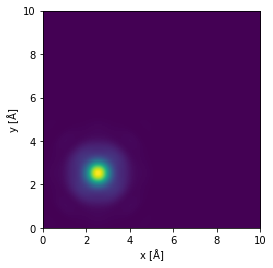

In [8]:
wave.plot(cmap='viridis')

<div class= "alert alert-info">

**Note:**

The axes convention for arrays representing a wave functions assigns the first axis to the $x$-axis and the second axis to the $y$-axis, and a larger array index implies a larger real-space coordinate. This is different from some image analysis programs. The correct way of displaying an array with `matplotplib` is given below.
    
```
import matplotlib.pyplot as plt
image = np.abs(waves.array[0]) ** 2
plt.imhow(image.T, extent=[0, waves.extent[0], 0, waves.extent[1]], origin='lower')
```     
  
</div>